# Ejercicio

Variar la arquitectura de la red y experimentar con las técnicas vistas en clase:
* Weight initialization.
* Regularización (Dropout, BatchNormalization).
* Distintos algoritmos de optimización.

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%tensorflow_version 2.x
from tensorflow.python.keras import backend as K
import tensorflow as tf
%matplotlib inline

tf.random.set_seed(0)

In [8]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8

#Dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True

# #To log device placement (on which device the operation ran)
# #Nothing gets printed in Jupyter, only if you run it standalone
# config.log_device_placement = True

sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [9]:
K.get_session()

In [10]:
#@title custom_callbacks.py
%%writefile custom_callbacks.py
import tensorflow.python.keras, math
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt
from pathlib import Path
import os

def save_weights(model, file):
    model.save_weights(file, overwrite=True)

def reset_weights(model, file):
    model.load_weights(file)
            

class CycleLearner(tensorflow.python.keras.callbacks.Callback):
    def __init__(self, lr, nb, n_cycle, cycle_len=1, cycle_mult=1,
                 snapshots=False, n_snapshots=5,
                 snapshots_name='temp_model', snapshots_folder='snapshots'):
        super().__init__()
        self.lr = lr
        self.nb = nb*cycle_len
        self.n_cycle = n_cycle
        self.cycle_len = cycle_len
        self.cycle_mult = cycle_mult
        self.snapshots = snapshots
        self.n_snapshots = n_snapshots
        self.start_snaps = n_cycle - n_snapshots
        self.snapshots_name = snapshots_name
        self.snapshots_folder = snapshots_folder
        self.lr_list = []
        self.losses = []
        self.iterations = []

        if not os.path.exists:
            os.mkdir(self.snapshots_folder, )
       
    def on_train_begin(self, logs={}):
        self.iteration,self.epoch = 0,0
        self.cycle_iter,self.cycle_count=0,0
        self.update_lr()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1

    def on_batch_end(self, batch, logs={}):
        self.iteration += 1
        self.lr_list.append(K.eval(self.model.optimizer.lr))
        loss = logs.get('loss')
        self.losses.append(loss)
        self.iterations.append(self.iteration)
        self.update_lr()
        if self.cycle_count == self.n_cycle:
            self.model.stop_training = True
    
    def on_cycle_end(self):
        self.cycle_iter = 0
        self.nb *= self.cycle_mult
        self.cycle_count += 1
        if self.snapshots and self.cycle_count>self.start_snaps:
            file = self.snapshots_folder +  '/'+ f'{self.snapshots_name}_{self.cycle_count}.hdf5'
            
            self.model.save_weights(file, overwrite=True)
    
    def update_lr(self):
        new_lr = self.calc_lr()
        K.set_value(self.model.optimizer.lr, new_lr)

    def calc_lr(self):
        if self.iteration<self.nb/20:
            self.cycle_iter += 1
            return self.lr/100.

        cos_out = np.cos(np.pi*(self.cycle_iter)/self.nb) + 1
        self.cycle_iter += 1
        if self.cycle_iter==self.nb:
            self.on_cycle_end()
            
        return self.lr / 2 * cos_out        
        
    def plot_loss(self, skip=10):
        plt.plot(self.iterations[skip:], self.losses[skip:])

    def plot_lr(self):
        plt.xlabel("iterations")
        plt.ylabel("learning rate")
        plt.plot(self.iterations, self.lr_list)


class LrFinder(tensorflow.python.keras.callbacks.Callback):
    def __init__(self, nb, start_lr=1e-5, end_lr=10):
        super().__init__()
        self.start_lr = start_lr
        self.lr = start_lr
        self.lr_mult = (end_lr/start_lr)**(1/nb)
        self.lr_list = []
        self.losses = []
        self.iterations = []
        self.derivatives = []
        
    def on_train_begin(self, logs={}):
        self.best = 1e9
        self.iteration = 0
        self.update_lr()

    def on_batch_end(self, batch, logs={}):
        self.iteration += 1
        self.lr_list.append(K.eval(self.model.optimizer.lr))
        loss = logs.get('loss')
        self.losses.append(loss)
        self.iterations.append(self.iteration)

        if math.isnan(loss) or loss>self.best*4:
            self.model.stop_training = True
        if loss<self.best:
            self.best=loss
        self.update_lr()
    
    def update_lr(self):
        new_lr = self.start_lr * (self.lr_mult**self.iteration)
        K.set_value(self.model.optimizer.lr, new_lr)
        
    def plot_loss(self):
        plt.plot(self.iterations[10:], self.losses[10:])

    def plot_lr(self):
        plt.xlabel("iterations")
        plt.ylabel("learning rate")
        plt.plot(self.iterations, self.lr_list)
        
    def plot(self, n_skip_start=2, xlim=None, ylim=None):
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lr_list[n_skip_start:], self.losses[n_skip_start:])
        plt.xscale('log')
        if ylim is not None: plt.ylim(top=ylim)
        if xlim is not None: plt.xlim(right=xlim)
        
    def plot_loss_variation(self, window_size=1, xlim_range=None, ylim_range=None):
        '''
        Parameters:
            window_size - number of batches for simple moving average to smooth out the curve.
        '''
        assert (window_size>0), "The parameter 'window_size' should be greater than 0"

        self.derivatives = []
        self.lr_list_on_xlim = []
        for i in range(len(self.lr_list)-window_size):
            if  self.lr_list[i] < xlim_range[0]:
                continue
            if  self.lr_list[i] > xlim_range[1]:
                break
            derivative = (self.losses[i + window_size] - self.losses[i]) / window_size
            self.derivatives.append(derivative)
            self.lr_list_on_xlim.append(self.lr_list[i])
      
        plt.ylabel("d/loss")        
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lr_list_on_xlim, self.derivatives)
        plt.xscale('log')
        if ylim_range is not None: plt.ylim(ylim_range)
        if xlim_range is not None: plt.xlim(xlim_range)



Writing custom_callbacks.py


##  MNIST

http://yann.lecun.com/exdb/mnist/

Base de datos de digitos escritos a mano.

* 60,000 imágenes de entrenamiento.
* 10,000 imágenes de test.

Cada imagen es de 28x28, en escala de grises.

In [11]:
from tensorflow.python.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'Train -> x: {x_train.shape}')
print(f'         y: {y_train.shape}')
print(f'Test -> x: {x_test.shape}')
print(f'        y: {y_test.shape}')

11493376/11490434 [==============================] - 0s 0us/step
Train -> x: (60000, 28, 28)
         y: (60000,)
Test -> x: (10000, 28, 28)
        y: (10000,)


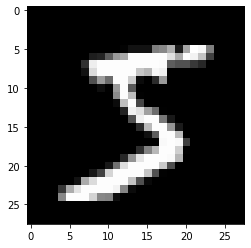

In [12]:
# Veamos una muestra
plt.imshow(x_train[0], 'gray');

In [13]:
y_train[0]

5

In [14]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Ajustamos las dimensiones de las imágenes

Para usar las imágenes en una multiplicación de matrices, esta necesita tener sólo 2 dimensiones.

In [15]:
x_train.shape

(60000, 28, 28)

In [16]:
x_train = x_train.reshape([60000, 28*28])
x_test = x_test.reshape([10000, 28*28])
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

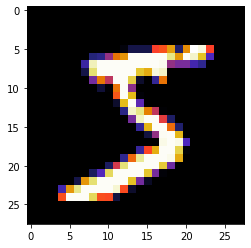

In [17]:
# Podemos usar el reshape de nuevo, para mostrar la imagen
plt.imshow(x_train[0].reshape([28,28]), 'CMRmap');

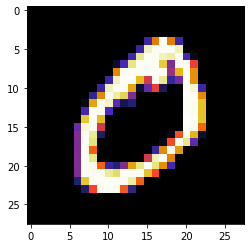

In [18]:
plt.imshow(x_train[1].reshape([28,28]), cmap='CMRmap');

## Definimos un modelo

In [103]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import RandomNormal, Zeros
from tensorflow.keras.optimizers import SGD
from keras.constraints import maxnorm

#from keras.layers.normalization import BatchNormalization
from custom_callbacks import save_weights

lr = 0.01
bs = 256
nb = math.ceil(len(x_train)/bs) # Nro de batches

K.clear_session()

#def create_model():
model = Sequential([
    Dense(128, input_dim=128, activation='relu',kernel_initializer=RandomNormal(stddev=0.01),input_shape=(784,),kernel_constraint=maxnorm(3),use_bias=False),
    Dropout(rate=0.4),
    Dense(64, activation='relu',kernel_initializer='he_normal'),
    Dropout(rate=0.3),
    Dense(32, activation='sigmoid'),
    Dropout(rate=0.2),
    Dense(10, activation='softmax')
    ])

model.compile(optimizer=SGD(lr,momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# La función de pérdida 'sparse_categorical_crossentropy' realiza automaticamente la conversión
# del target a one-hot encoding.
   

# Guardamos los pesos del modelo para poder usarlos posteriormente al re-inicializar los pesos
save_weights(model, 'model')

print("Number of weights after calling the model:", len(model.weights))
model.summary()

Number of weights after calling the model: 7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100352    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (De

## Usemos el método de Learning rate finder

In [104]:
from custom_callbacks import LrFinder, reset_weights

lr_finder = LrFinder(nb)

model.fit(x_train, y_train, batch_size=bs, callbacks=[lr_finder]);

235/235 [==============================] - 2s 8ms/step - loss: 5.4728 - accuracy: 0.2105


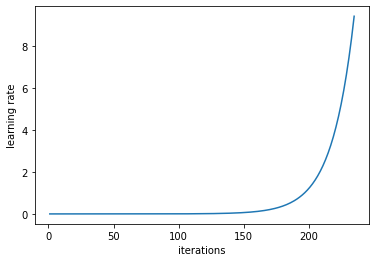

In [105]:
lr_finder.plot_lr()

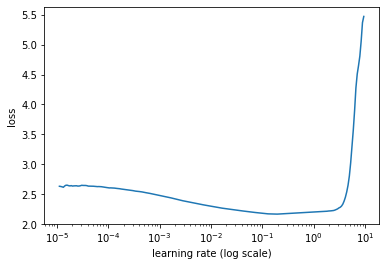

In [106]:
lr_finder.plot()

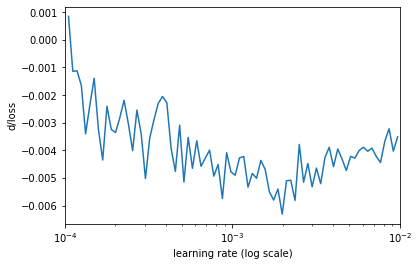

In [107]:
#d/loss es derivada del loss

#window_size - number of batches for simple moving average to smooth out the curve.
window_size = 1
#You can modify the range to adapt your plot
xlim_range=[1e-4, 1e-2]

lr_finder.plot_loss_variation(window_size=window_size, xlim_range=xlim_range)

In [108]:
index_of_the_min_derivative = np.argmin(lr_finder.derivatives)

index_of_the_min_derivative

50

In [109]:
lr = lr_finder.lr_list_on_xlim[index_of_the_min_derivative]

lr

0.0019855113

## Entrenamiento

In [110]:
# Reseteamos los pesos y compilamos el modelo con el nuevo lr porque la variable ya fue sobreescrita
reset_weights(model, 'model')

model.compile(SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [111]:
log = model.fit(x_train, y_train, batch_size=bs, epochs=6, validation_data=(x_test, y_test))

Epoch 1/6
235/235 [==============================] - 2s 8ms/step - loss: 1.9794 - accuracy: 0.3189 - val_loss: 1.2474 - val_accuracy: 0.7792
Epoch 2/6
235/235 [==============================] - 2s 7ms/step - loss: 1.6117 - accuracy: 0.5139 - val_loss: 1.0495 - val_accuracy: 0.8334
Epoch 3/6
235/235 [==============================] - 2s 7ms/step - loss: 1.4564 - accuracy: 0.5978 - val_loss: 0.9229 - val_accuracy: 0.8627
Epoch 4/6
235/235 [==============================] - 2s 7ms/step - loss: 1.3468 - accuracy: 0.6493 - val_loss: 0.8417 - val_accuracy: 0.8656
Epoch 5/6
235/235 [==============================] - 2s 7ms/step - loss: 1.2605 - accuracy: 0.6845 - val_loss: 0.7752 - val_accuracy: 0.8817
Epoch 6/6
235/235 [==============================] - 2s 7ms/step - loss: 1.1854 - accuracy: 0.7137 - val_loss: 0.7174 - val_accuracy: 0.8928


In [112]:
def show_results(model, log):
    loss, acc = model.evaluate(x_test, y_test, batch_size=512, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    
    val_loss = log.history['val_loss']
    val_acc = log.history['val_accuracy']
        
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['accuracy'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

Loss     = 0.7174
Accuracy = 0.8928


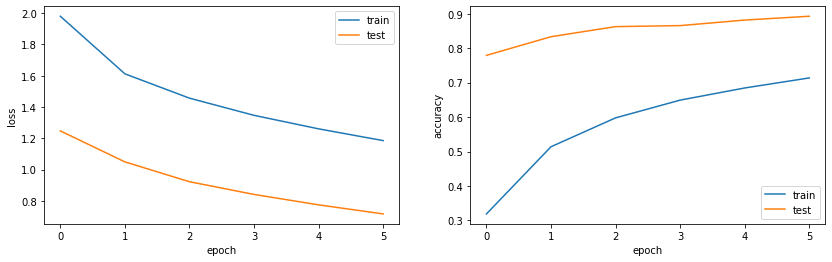

In [113]:
show_results(model, log)

## Cycling learning rates

In [114]:
from custom_callbacks import CycleLearner

cycle_learner = CycleLearner(lr, nb, n_cycle=3)

In [115]:
reset_weights(model, 'model')

log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=(x_test, y_test), callbacks=[cycle_learner])
# Nota: la cantidad de épocas la va a controlar el callback. Cada ciclo es igual a la cantidad de batchs (nb)

Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 2.0830 - accuracy: 0.2710 - val_loss: 1.4511 - val_accuracy: 0.6789
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 1.7689 - accuracy: 0.4218 - val_loss: 1.2228 - val_accuracy: 0.7822
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 1.6282 - accuracy: 0.5021 - val_loss: 1.1061 - val_accuracy: 0.8223


Loss     = 1.1061
Accuracy = 0.8223


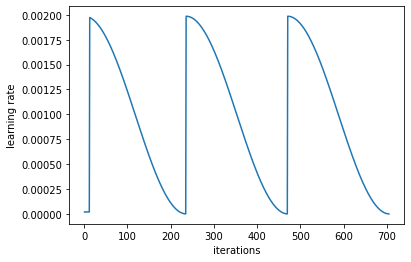

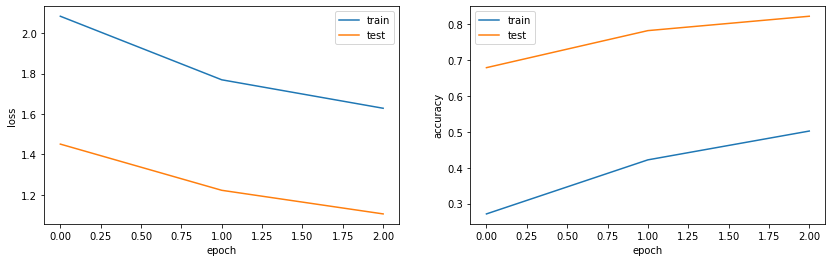

In [116]:
cycle_learner.plot_lr()
show_results(model, log)

In [117]:
# El parametro "cycle_mult" permite que cada ciclo sea mayor al anterior,
# en este caso el doble del anterior

reset_weights(model, 'model')

cycle_learner = CycleLearner(lr/2, nb, n_cycle=3, cycle_mult=2)
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=(x_test, y_test), callbacks=[cycle_learner])

Epoch 1/100
235/235 [==============================] - 2s 8ms/step - loss: 2.2229 - accuracy: 0.2139 - val_loss: 1.6504 - val_accuracy: 0.5581
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 1.9095 - accuracy: 0.3469 - val_loss: 1.3288 - val_accuracy: 0.7426
Epoch 3/100
235/235 [==============================] - 2s 8ms/step - loss: 1.7752 - accuracy: 0.4193 - val_loss: 1.2886 - val_accuracy: 0.7638
Epoch 4/100
235/235 [==============================] - 2s 8ms/step - loss: 1.6971 - accuracy: 0.4652 - val_loss: 1.1505 - val_accuracy: 0.8156
Epoch 5/100
235/235 [==============================] - 2s 8ms/step - loss: 1.5982 - accuracy: 0.5238 - val_loss: 1.0756 - val_accuracy: 0.8387
Epoch 6/100
235/235 [==============================] - 2s 8ms/step - loss: 1.5481 - accuracy: 0.5512 - val_loss: 1.0488 - val_accuracy: 0.8446
Epoch 7/100
235/235 [==============================] - 2s 8ms/step - loss: 1.5336 - accuracy: 0.5604 - val_loss: 1.0447 - val_accuracy: 0.8467

Loss     = 1.0447
Accuracy = 0.8467


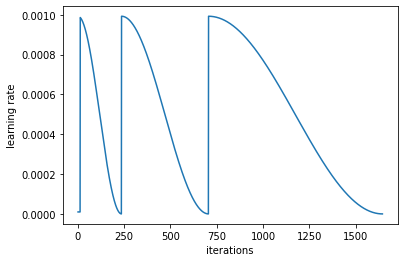

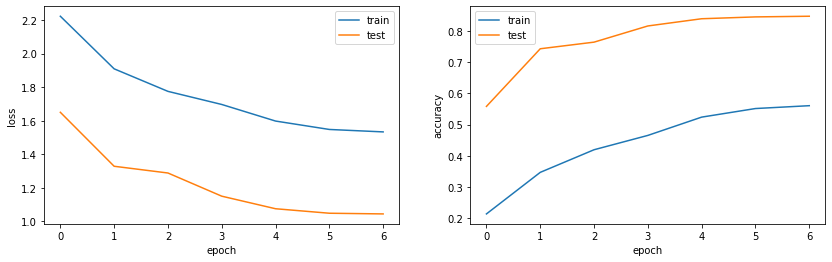

In [118]:
cycle_learner.plot_lr()
show_results(model, log)

## Snapshot ensembles

In [119]:
%mkdir -p snapshots

In [120]:
# Iniciamos el entrenamiento de forma normal
reset_weights(model, 'model')

cycle_learner = CycleLearner(lr, nb, n_cycle=3, cycle_mult=2)
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=(x_test, y_test), callbacks=[cycle_learner])

Epoch 1/100
235/235 [==============================] - 2s 8ms/step - loss: 2.0728 - accuracy: 0.2747 - val_loss: 1.4407 - val_accuracy: 0.6751
Epoch 2/100
235/235 [==============================] - 2s 8ms/step - loss: 1.7380 - accuracy: 0.4387 - val_loss: 1.1429 - val_accuracy: 0.8133
Epoch 3/100
235/235 [==============================] - 2s 9ms/step - loss: 1.6011 - accuracy: 0.5202 - val_loss: 1.1071 - val_accuracy: 0.8249
Epoch 4/100
235/235 [==============================] - 2s 9ms/step - loss: 1.5143 - accuracy: 0.5703 - val_loss: 0.9697 - val_accuracy: 0.8569
Epoch 5/100
235/235 [==============================] - 2s 8ms/step - loss: 1.4009 - accuracy: 0.6256 - val_loss: 0.8967 - val_accuracy: 0.8662
Epoch 6/100
235/235 [==============================] - 2s 8ms/step - loss: 1.3443 - accuracy: 0.6525 - val_loss: 0.8646 - val_accuracy: 0.8704
Epoch 7/100
235/235 [==============================] - 2s 7ms/step - loss: 1.3246 - accuracy: 0.6631 - val_loss: 0.8586 - val_accuracy: 0.8738

In [121]:
# Ahora activamos los snapshots
cycle_learner = CycleLearner(lr/2, nb, n_cycle=3, cycle_len=2, snapshots=True, snapshots_name='mnist_test')
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=(x_test, y_test), callbacks=[cycle_learner])

Epoch 1/100
235/235 [==============================] - 2s 8ms/step - loss: 1.3121 - accuracy: 0.6669 - val_loss: 0.8329 - val_accuracy: 0.8771
Epoch 2/100
235/235 [==============================] - 2s 8ms/step - loss: 1.2818 - accuracy: 0.6792 - val_loss: 0.8244 - val_accuracy: 0.8778
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 1.2639 - accuracy: 0.6867 - val_loss: 0.8001 - val_accuracy: 0.8811
Epoch 4/100
235/235 [==============================] - 2s 8ms/step - loss: 1.2402 - accuracy: 0.6981 - val_loss: 0.7927 - val_accuracy: 0.8847
Epoch 5/100
235/235 [==============================] - 2s 8ms/step - loss: 1.2241 - accuracy: 0.7023 - val_loss: 0.7681 - val_accuracy: 0.8870
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 1.2058 - accuracy: 0.7103 - val_loss: 0.7621 - val_accuracy: 0.8870


Loss     = 0.7621
Accuracy = 0.8870


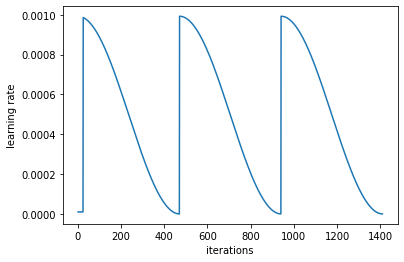

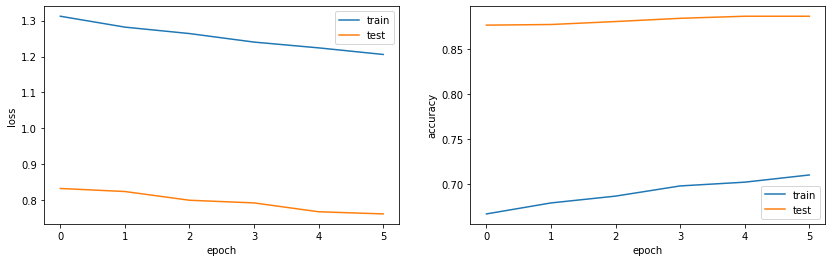

In [122]:
# Noten la diferencia de usar "cycle_len=2" en lugar de "cycle_mult=2" en CycleLearner
cycle_learner.plot_lr()
show_results(model, log)

In [123]:
# Veamos los archivos creados para los snapshots
snapshots = 'snapshots'
for file in os.listdir(snapshots):
    print(file)

mnist_test_3.hdf5
mnist_test_1.hdf5
mnist_test_2.hdf5


In [124]:
%ls snapshots

mnist_test_1.hdf5  mnist_test_2.hdf5  mnist_test_3.hdf5


In [125]:
# Veamos ahora usando snapshots
snapshots_results = np.zeros([10000,10])

for file in os.listdir(snapshots):
    model.load_weights(os.path.join(snapshots,file))
    snapshots_results += model.predict(x_test) / 3
    
acc = (snapshots_results.argmax(axis=1) == y_test).mean()
print(f'Snapshot accuracy = {acc}')

Snapshot accuracy = 0.8844


# Ejercicio 2

In [114]:
from keras.models import Sequential
from keras.layers import Dense

def build_model(n_layers, input_dim, units, activation, initializer):
    if isinstance(units, list):
        assert len(units) == n_layers
    else:
        units = [units] * n_layers
        
    model = Sequential()
    # Adds first hidden layer with input_dim parameter
    model.add(Dense(units=units[0], 
                    input_dim=input_dim, 
                    activation=activation,
                    kernel_initializer=initializer, 
                    name='h1'))
    
    # Adds remaining hidden layers
    for i in range(2, n_layers + 1):
        model.add(Dense(units=units[i-1], 
                        activation=activation, 
                        kernel_initializer=initializer, 
                        name='h{}'.format(i)))
    
    # Adds output layer
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer=initializer, name='o'))
    # Compiles the model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])
    return model

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


# Otra base de datos para practicar:

``` python
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import RandomNormal, Zeros
from tensorflow.keras.optimizers import SGD

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

model = Sequential([
    Dense(..., activation='relu', kernel_initializer=RandomNormal(stddev=0.01), bias_initializer=Zeros(), input_shape=(...,)),
    Dropout(rate=0.2),
    Dense(..., activation='relu'),
    Dropout(rate=0.2),
    Dense(..., activation='softmax')
])
```

In [128]:
from tensorflow.python.keras.datasets import fashion_mnist
(x1_train, y1_train), (x1_test, y1_test) = fashion_mnist.load_data()
print(f'Train -> x1: {x1_train.shape}')
print(f'         y1: {y1_train.shape}')
print(f'Test -> x1: {x1_test.shape}')
print(f'        y1: {y1_test.shape}')

Train -> x1: (60000, 28, 28)
         y1: (60000,)
Test -> x1: (10000, 28, 28)
        y1: (10000,)


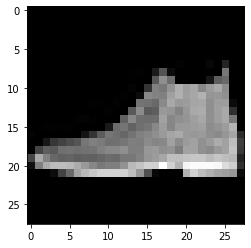

In [130]:
# Veamos una muestra
plt.imshow(x1_test[0], 'gray');

In [134]:
set(y1_train); 
x1_test.shape

(10000, 28, 28)

In [135]:
x1_train = x1_train.reshape([60000, 28*28])
x1_test = x1_test.reshape([10000, 28*28])
x1_train.shape, x1_test.shape

((60000, 784), (10000, 784))

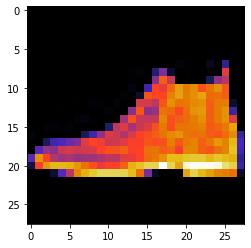

In [137]:
# Podemos usar el reshape de nuevo, para mostrar la imagen
plt.imshow(x1_test[0].reshape([28,28]), 'CMRmap');

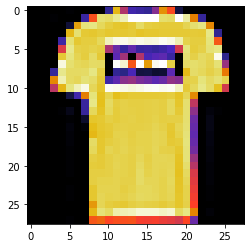

In [138]:
plt.imshow(x1_train[1].reshape([28,28]), cmap='CMRmap')

In [179]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import RandomNormal, Zeros
from tensorflow.keras.optimizers import SGD
from keras.constraints import maxnorm

#from keras.layers.normalization import BatchNormalization
from custom_callbacks import save_weights

lr2 = 0.05
bs2 = 256
nb2 = math.ceil(len(x1_train)/bs2) # Nro de batches

K.clear_session()

#def create_model():
model2 = Sequential([
    Dense(128, input_dim=128, activation='relu',kernel_initializer=RandomNormal(stddev=0.01),input_shape=(784,),kernel_constraint=maxnorm(3),use_bias=False),
    Dropout(rate=0.4),
    Dense(64, activation='relu',kernel_initializer='he_normal'),
    #Dropout(rate=0.2),
    Dense(32, activation='sigmoid'),
    Dropout(rate=0.2),
    Dense(10, activation='softmax')
    ])

model2.compile(optimizer=SGD(lr2,momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# La función de pérdida 'sparse_categorical_crossentropy' realiza automaticamente la conversión
# del target a one-hot encoding.
   

# Guardamos los pesos del modelo para poder usarlos posteriormente al re-inicializar los pesos
save_weights(model2, 'model2')

print("Number of weights after calling the model2:", len(model2.weights))
model2.summary()

Number of weights after calling the model2: 7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100352    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 111,018
Trainable params: 111,018
Non-trainable params: 0
____

In [180]:
from custom_callbacks import LrFinder, reset_weights

lr_finder2 = LrFinder(nb2)

model2.fit(x1_train, y1_train, batch_size=bs2, callbacks=[lr_finder2]);

235/235 [==============================] - 1s 6ms/step - loss: 7.5294 - accuracy: 0.2203


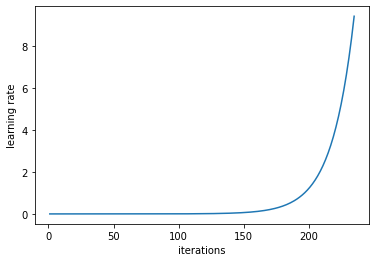

In [181]:
lr_finder2.plot_lr()

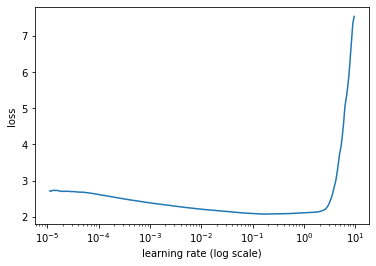

In [182]:
lr_finder2.plot()

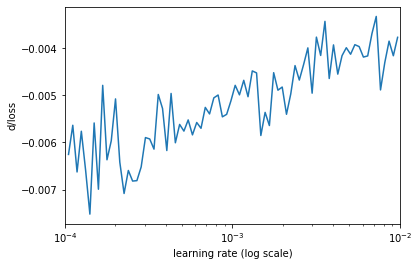

In [183]:
#d/loss es derivada del loss

#window_size - number of batches for simple moving average to smooth out the curve.
window_size = 1
#You can modify the range to adapt your plot
xlim_range=[1e-4, 1e-2]

lr_finder2.plot_loss_variation(window_size=window_size, xlim_range=xlim_range)

In [184]:
index_of_the_min_derivative2 = np.argmin(lr_finder2.derivatives)
index_of_the_min_derivative2

5

In [185]:
lr2 = lr_finder2.lr_list_on_xlim[index_of_the_min_derivative2]
lr2

0.00014090817

## Entrenamiento

In [187]:
# Reseteamos los pesos y compilamos el modelo con el nuevo lr porque la variable ya fue sobreescrita
reset_weights(model2, 'model2')

model2.compile(SGD(lr2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [188]:
log2 = model2.fit(x1_train, y1_train, batch_size=bs2, epochs=6, validation_data=(x1_test, y1_test))

Epoch 1/6
235/235 [==============================] - 2s 7ms/step - loss: 2.3095 - accuracy: 0.1724 - val_loss: 1.8842 - val_accuracy: 0.3365
Epoch 2/6
235/235 [==============================] - 1s 6ms/step - loss: 2.0130 - accuracy: 0.2707 - val_loss: 1.7062 - val_accuracy: 0.4430
Epoch 3/6
235/235 [==============================] - 1s 6ms/step - loss: 1.8810 - accuracy: 0.3315 - val_loss: 1.5810 - val_accuracy: 0.5262
Epoch 4/6
235/235 [==============================] - 1s 6ms/step - loss: 1.7924 - accuracy: 0.3753 - val_loss: 1.5018 - val_accuracy: 0.5727
Epoch 5/6
235/235 [==============================] - 2s 6ms/step - loss: 1.7269 - accuracy: 0.4116 - val_loss: 1.4428 - val_accuracy: 0.6009
Epoch 6/6
235/235 [==============================] - 2s 7ms/step - loss: 1.6782 - accuracy: 0.4401 - val_loss: 1.3913 - val_accuracy: 0.6192


In [189]:
def show_results(model2, log2):
    loss, acc = model2.evaluate(x1_test, y1_test, batch_size=512, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    
    val_loss = log2.history['val_loss']
    val_acc = log2.history['val_accuracy']
        
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log2.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log2.history['accuracy'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

Loss     = 1.3913
Accuracy = 0.6192


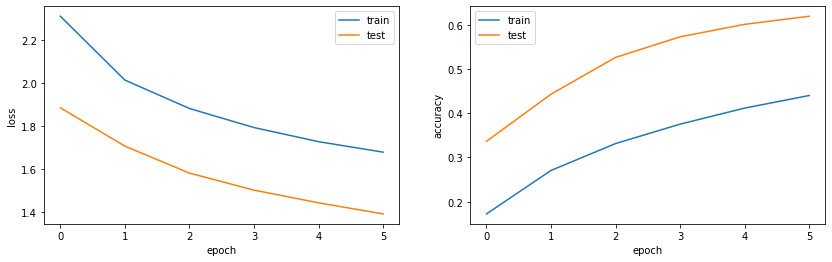

In [190]:
show_results(model2, log2)

In [191]:
from custom_callbacks import CycleLearner

cycle_learner2 = CycleLearner(lr2, nb2, n_cycle=3)

In [192]:
reset_weights(model2, 'model2')

log2 = model2.fit(x1_train, y1_train, batch_size=bs2, epochs=100,
                validation_data=(x1_test, y1_test), callbacks=[cycle_learner2])
# Nota: la cantidad de épocas la va a controlar el callback. Cada ciclo es igual a la cantidad de batchs (nb)

Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 2.4093 - accuracy: 0.1470 - val_loss: 2.1044 - val_accuracy: 0.2197
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 2.1622 - accuracy: 0.2080 - val_loss: 1.8825 - val_accuracy: 0.3511
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 2.0378 - accuracy: 0.2563 - val_loss: 1.7646 - val_accuracy: 0.3957


Loss     = 1.7646
Accuracy = 0.3957


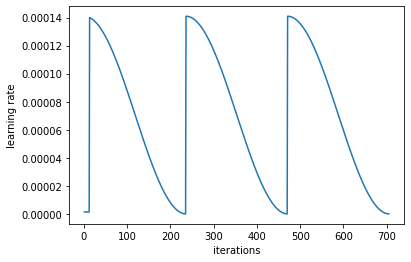

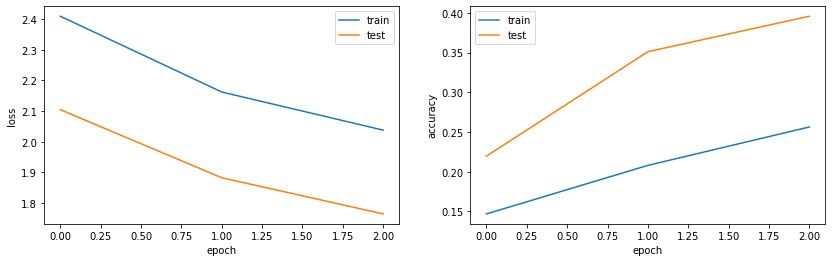

In [193]:
cycle_learner2.plot_lr()
show_results(model2, log2)

In [194]:
# El parametro "cycle_mult" permite que cada ciclo sea mayor al anterior,
# en este caso el doble del anterior

reset_weights(model2, 'model2')

cycle_learner2 = CycleLearner(lr2/2, nb2, n_cycle=3, cycle_mult=2)
log2 = model2.fit(x1_train, y1_train, batch_size=bs2, epochs=100,
                validation_data=(x1_test, y1_test), callbacks=[cycle_learner2])

Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 2.5305 - accuracy: 0.1256 - val_loss: 2.3049 - val_accuracy: 0.1628
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 2.2958 - accuracy: 0.1681 - val_loss: 2.0006 - val_accuracy: 0.2779
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 2.1894 - accuracy: 0.2001 - val_loss: 1.9639 - val_accuracy: 0.3041
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 2.1122 - accuracy: 0.2300 - val_loss: 1.8284 - val_accuracy: 0.3872
Epoch 5/100
235/235 [==============================] - 2s 7ms/step - loss: 2.0185 - accuracy: 0.2681 - val_loss: 1.7519 - val_accuracy: 0.4251
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 1.9697 - accuracy: 0.2884 - val_loss: 1.7228 - val_accuracy: 0.4413
Epoch 7/100
235/235 [==============================] - 2s 7ms/step - loss: 1.9582 - accuracy: 0.2951 - val_loss: 1.7189 - val_accuracy: 0.4444

Loss     = 1.7189
Accuracy = 0.4444


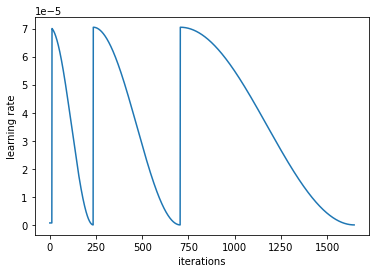

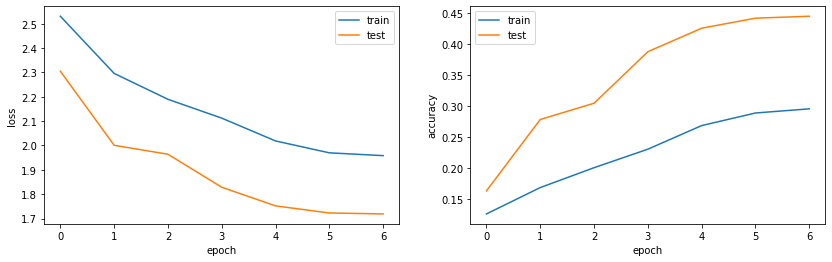

In [195]:
cycle_learner2.plot_lr()
show_results(model2, log2)

## Snapshot ensembles

In [196]:
%mkdir -p snapshots2

In [197]:
# Iniciamos el entrenamiento de forma normal
reset_weights(model2, 'model2')

cycle_learner2 = CycleLearner(lr2, nb2, n_cycle=3, cycle_mult=2)
log2 = model2.fit(x1_train, y1_train, batch_size=bs2, epochs=100,
                validation_data=(x1_test, y1_test), callbacks=[cycle_learner2])

Epoch 1/100
235/235 [==============================] - 2s 8ms/step - loss: 2.4052 - accuracy: 0.1471 - val_loss: 2.1036 - val_accuracy: 0.2359
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 2.1409 - accuracy: 0.2198 - val_loss: 1.8106 - val_accuracy: 0.3928
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 2.0153 - accuracy: 0.2682 - val_loss: 1.7739 - val_accuracy: 0.4080
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 1.9348 - accuracy: 0.3049 - val_loss: 1.6386 - val_accuracy: 0.5032
Epoch 5/100
235/235 [==============================] - 2s 7ms/step - loss: 1.8410 - accuracy: 0.3483 - val_loss: 1.5558 - val_accuracy: 0.5540
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 1.7959 - accuracy: 0.3724 - val_loss: 1.5295 - val_accuracy: 0.5633
Epoch 7/100
235/235 [==============================] - 2s 7ms/step - loss: 1.7817 - accuracy: 0.3807 - val_loss: 1.5271 - val_accuracy: 0.5665

In [198]:
# Ahora activamos los snapshots
cycle_learner2 = CycleLearner(lr2/2, nb2, n_cycle=3, cycle_len=2, snapshots=True, snapshots_name='mnist_test')
log2 = model2.fit(x1_train, y1_train, batch_size=bs2, epochs=100,
                validation_data=(x1_test, y1_test), callbacks=[cycle_learner2])

Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 1.7716 - accuracy: 0.3864 - val_loss: 1.5011 - val_accuracy: 0.5798
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 1.7537 - accuracy: 0.3959 - val_loss: 1.4943 - val_accuracy: 0.5804
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 1.7398 - accuracy: 0.4031 - val_loss: 1.4663 - val_accuracy: 0.5992
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 1.7246 - accuracy: 0.4127 - val_loss: 1.4613 - val_accuracy: 0.5996
Epoch 5/100
235/235 [==============================] - 2s 7ms/step - loss: 1.7104 - accuracy: 0.4208 - val_loss: 1.4327 - val_accuracy: 0.6148
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 1.6993 - accuracy: 0.4290 - val_loss: 1.4279 - val_accuracy: 0.6169


Loss     = 1.4279
Accuracy = 0.6169


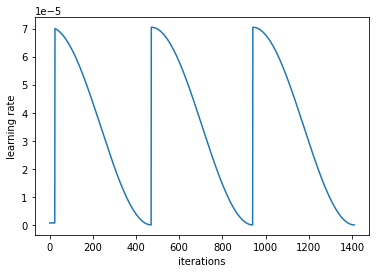

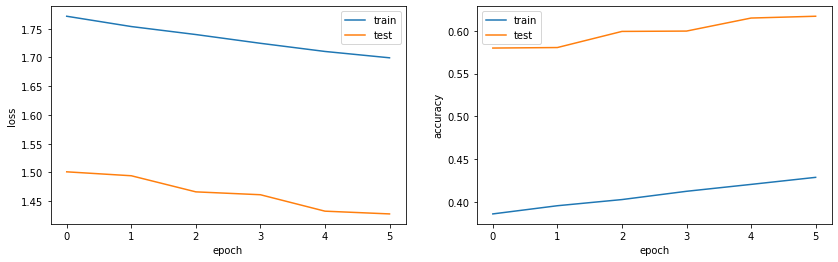

In [199]:
# Notar la diferencia de usar "cycle_len=2" en lugar de "cycle_mult=2" en CycleLearner
cycle_learner2.plot_lr()
show_results(model2, log2)

In [207]:
# Veamos los archivos creados para los snapshots
snapshots2 = 'snapshots'
for file in os.listdir(snapshots2):
    print(file)

mnist_test_3.hdf5
mnist_test_1.hdf5
mnist_test_2.hdf5


In [208]:
%ls snapshots2

In [210]:
# Veamos ahora usando snapshots
snapshots_results = np.zeros([10000,10])

for file in os.listdir(snapshots2):
    model2.load_weights(os.path.join(snapshots2,file))
    snapshots_results += model2.predict(x1_test) / 3
    
acc2 = (snapshots_results.argmax(axis=1) == y1_test).mean()
print(f'Snapshot accuracy = {acc2}')

Snapshot accuracy = 0.6041
